In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from vod.configuration import KittiLocations
from vod.frame import FrameTransformMatrix, FrameDataLoader
from my_fuse_radar.utils import read_kitti_label_file, get_base_box_vertices
kitti_locations = KittiLocations(root_dir='/datasets/vod')

def get_bev_bbox_radar(m_objs, t_lidar_camera, t_radar_lidar):
    all_bev_bboxes = []
    for m_obj in m_objs:
        x, y, z, rotation = m_obj['x'], m_obj['y'], m_obj['z'], -(m_obj['rotation'] + np.pi / 2)
        bbox_center_lidar = (t_lidar_camera @ np.array([x, y, z, 1]))[:3]
        rot_matrix = np.array([[np.cos(rotation), -np.sin(rotation), 0],
                               [np.sin(rotation), np.cos(rotation), 0],
                               [0, 0, 1]])
        base_box_vertices = get_base_box_vertices(m_obj)  # shape (3, 8)
        box_corners_lidar = (rot_matrix @ base_box_vertices).T + bbox_center_lidar
        corners_lidar_hom = np.hstack([box_corners_lidar, np.ones((8, 1))])
        corners_radar = (t_radar_lidar @ corners_lidar_hom.T).T[:, :3]   # (8, 3)
        bev_corners = corners_radar[:4, :2]  # shape (4, 2)，只要x, y坐标
        all_bev_bboxes.append(bev_corners)
    return np.array(all_bev_bboxes)

def draw_all_bboxes(bboxes, color='black'):
    for corners in bboxes:
        corners = np.vstack([corners, corners[0]])  # 闭合多边形
        plt.plot(corners[:, 0], corners[:, 1], '-', linewidth=3, color=color)

In [7]:
frame_number = 10
frame_data = FrameDataLoader(kitti_locations=kitti_locations, frame_number=str(frame_number).zfill(5))
transforms = FrameTransformMatrix(frame_data)

_, moving_objs = read_kitti_label_file(frame_data.raw_labels)
all_bboxes = get_bev_bbox_radar(moving_objs, transforms.t_lidar_camera, transforms.t_radar_lidar)

In [8]:
radar_points = np.fromfile('/datasets/vod/radar_5frames/training/velodyne/00010.bin', dtype=np.float32).reshape(-1, 7)
label_mos = np.fromfile('/datasets/vod/my_radar_5frames/training/label_mos/00010.label', dtype=np.uint8)

rcs = radar_points[:, 3]#radar_points[:, 3]


gt_moving_points = np.array(radar_points[label_mos == 1])
gt_static_points = np.array(radar_points[label_mos == 0])
gt_static_rcs = rcs[label_mos == 0]

th_moving_points = []
th_static_points = []
th_static_rcs = []
for point in radar_points:
    if abs(point[5]) > 1.0:
        th_moving_points.append(point)
    else:
        th_static_points.append(point)
        th_static_rcs.append(point[3])
th_moving_points = np.array(th_moving_points)
th_static_points = np.array(th_static_points)
th_static_rcs = np.array(th_static_rcs)

def rotate_points(points, center, angle):
    """
    将一组 2D 点绕 center 逆旋转 angle，用于视觉对齐目标。
    """
    rot_mat = np.array([
        [np.cos(-angle), -np.sin(-angle)],
        [np.sin(-angle),  np.cos(-angle)]
    ])
    return (rot_mat @ (points - center).T).T + center

target = moving_objs[7]
yaw = -(target['rotation'] + np.pi / 2)
# 坐标转换：camera → lidar → radar
center_cam = np.array([target['x'], target['y'], target['z'], 1])
center_lidar = (transforms.t_lidar_camera @ center_cam)[:3]
center_radar = (transforms.t_radar_lidar @ np.append(center_lidar, 1))[:3]
center_xy = center_radar[:2]

# 只取 x, y
gt_static_xy = gt_static_points[:, :2]
gt_moving_xy = gt_moving_points[:, :2]
th_static_xy = th_static_points[:, :2]
th_moving_xy = th_moving_points[:, :2]
# 旋转点云
gt_static_points = rotate_points(gt_static_xy, center_xy, yaw)
gt_moving_points = rotate_points(gt_moving_xy, center_xy, yaw)
th_static_points = rotate_points(th_static_xy, center_xy, yaw)
th_moving_points = rotate_points(th_moving_xy, center_xy, yaw)
# 旋转 bbox
rotated_bboxes = np.array([
    rotate_points(bbox, center_xy, yaw) for bbox in all_bboxes
])

x_min,x_max = np.percentile(gt_static_points[:, 0], [1, 99])
y_min,y_max = np.percentile(gt_static_points[:, 1], [1, 99])


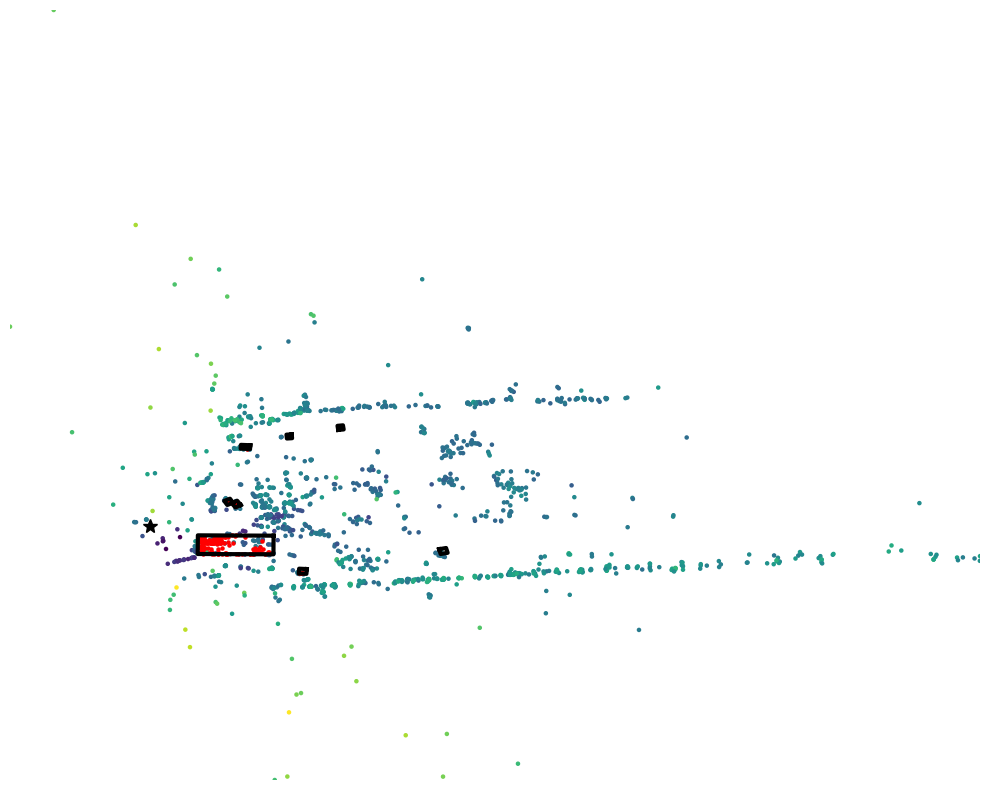

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(0, 0, 'k*', markersize=10, label='origin')
plt.scatter(gt_static_points[:,0], gt_static_points[:,1], c=gt_static_rcs, cmap='viridis', s=5, label='static')
plt.scatter(gt_moving_points[:,0], gt_moving_points[:,1], c='red', s=5, label='moving')
# plt.scatter(th_static_points[:, 0], th_static_points[:, 1], c=th_static_rcs, cmap='viridis', s=5, label='static')
# plt.scatter(th_moving_points[:, 0], th_moving_points[:, 1], c='red', s=5, label='moving')
draw_all_bboxes(rotated_bboxes)

# plt.legend(ncol=3, loc='lower center',fontsize=20)
plt.xticks([])
plt.yticks([])

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.autoscale(tight=True)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

plt.savefig('/home/yu/OpenPCDet/gt_segmentation.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [10]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#
# axes[0].plot(0, 0, 'k*', markersize=10, label='origin')
# axes[0].scatter(th_static_points[:, 0], th_static_points[:, 1], c=th_static_rcs, cmap='viridis', s=5, label='static')
# axes[0].scatter(th_moving_points[:, 0], th_moving_points[:, 1], c='red', s=5, label='moving')
#
# axes[1].plot(0, 0, 'k*', markersize=10, label='origin')
# axes[1].scatter(gt_static_points[:, 0], gt_static_points[:, 1], c=gt_static_rcs, cmap='viridis', s=5, label='static')
# axes[1].scatter(gt_moving_points[:, 0], gt_moving_points[:, 1], c='red', s=5, label='moving')
#
# for corners in rotated_bboxes:
#     corners = np.vstack([corners, corners[0]])  # 闭合多边形
#     axes[0].plot(corners[:, 0], corners[:, 1], '-', linewidth=1.8, color='darkviolet')
#     axes[1].plot(corners[:, 0], corners[:, 1], '-', linewidth=1.8, color='darkviolet')
#
# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     for spine in ax.spines.values():
#         spine.set_visible(False)
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
#     ax.autoscale(tight=True)
#
# # Shared legend at bottom
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, fontsize=18)
# plt.tight_layout()  # leave space for legend
#
# # plt.savefig("your_plot.pdf", format='pdf', bbox_inches='tight')
# plt.show()